In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.python.client import device_lib

config = tf.ConfigProto(allow_soft_placement=True, 
                        log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 

tf.keras.backend.set_session(sess)

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[u'/device:GPU:0']

In [39]:
def evaluate_model(model):
    model.summary()
    # evaluate the model using the test data
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("Test loss: %.4f, accuracy: %.4f" % (test_loss, test_acc))

def visualize_loss_history(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_loss"], label="Validation loss")
    plt.plot(history["loss"], label="Training loss")
    plt.legend()

def visualize_accuracy_history(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_acc"], label="Validation accuracy")
    plt.plot(history["acc"], label="Training accuracy")
    plt.legend()

In [86]:
import json
import time

def save_history(history, filename):
    with open(filename + '_%s.json' % str(time.time()), 'w') as f:
        json.dump(history, f)
        
def save_weights(model, file):
    model.save_weights(file + "_%s.h5" % str(time.time()))
        
def join_histories(h1, h2):
    return {
        'acc': h1['acc'] + h2['acc'],
        'loss': h1['loss'] + h2['loss'],
        'val_acc': h1['val_acc'] + h2['val_acc'],
        'val_loss': h1['val_loss'] + h2['val_loss']
    }
        
# checkpoint
filepath="weights-improvement-mt-{epoch:03d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_acc',
                                                verbose=1, 
                                                save_best_only=True,
                                                mode='max')

callbacks_list = [checkpoint]

## Analysis of the dataset

In [41]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = x_train.shape[1:]
num_classes = np.unique(y_train).shape[0]

print("number of classes:", num_classes)
print("input shape:", input_shape)
print("Image data type:", x_train.dtype)

('x_train shape:', (50000, 32, 32, 3))
(50000, 'train samples')
(10000, 'test samples')
('number of classes:', 10)
('input shape:', (32, 32, 3))
('Image data type:', dtype('uint8'))


The dataset consists of 60000 images of size 32x32 pixels. The images are rgb (3 channels). There are 10 classes in the dataset.

### Visualisation of the dataset

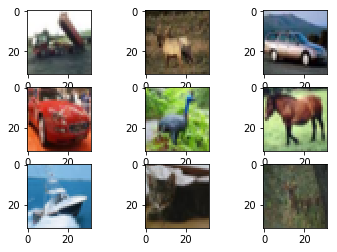

In [42]:
for row in range(3):
    for col in range(3):
        idx = row * 3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(x_train[idx + 1])

(50000, 1)


<BarContainer object of 10 artists>

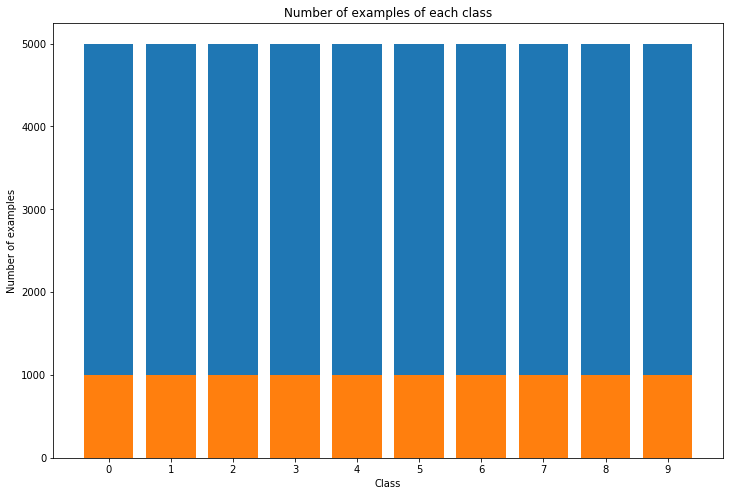

In [43]:
print(y_train.shape)
class_distribution_train = Counter(y_train[:,0])
class_distribution_test = Counter(y_test[:,0])
x = range(10)
train_y = [class_distribution_train[cls] for cls in x]
test_y = [class_distribution_test[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of examples of each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, train_y)
plt.bar(x, test_y)

The dataset is evenly distributed across the 10 classes.

### Normalize the dataset

In [44]:
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### Split out validation data

In [45]:
train_val_split = 0.85 # Percentage of data to use in training set
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
# Select random indexes for train/val set
idx_train = indexes[:int(train_val_split * x_train.shape[0])]
idx_val = indexes[int(train_val_split * x_train.shape[0]):]

x_val_data = x_train[idx_val]
y_val_data = y_train[idx_val]

x_train_data = x_train[idx_train]
y_train_data = y_train[idx_train]

print("Training images:", x_train_data.shape)
print("Validation images:", x_val_data.shape)
print("Test images:", x_test.shape)

('Training images:', (42500, 32, 32, 3))
('Validation images:', (7500, 32, 32, 3))
('Test images:', (10000, 32, 32, 3))


### Data augmentation

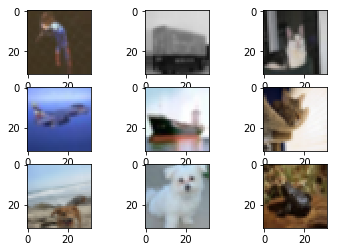

In [46]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train_data)

for x_batch, y_batch in datagen.flow(x_train_data,
                                     y_train_data,
                                     batch_size=9):
    for i in range(0, 9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i])
    plt.show()
    break

Data augmentation rotates, shifts and flips the images, and gives us more varied training data, thus preventing overfitting

## Known model

### Model definition

In [47]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.MaxPool2D())
model1.add(tf.keras.layers.Conv2D(64, (3, 3)))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.MaxPool2D())
model1.add(tf.keras.layers.Conv2D(128, (3, 3)))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.MaxPool2D())

model1.add(tf.keras.layers.Flatten())

model1.add(tf.keras.layers.Dense(128))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.Dense(64))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.Dense(num_classes))
model1.add(tf.keras.layers.Activation('softmax'))

### Training the model

In [48]:
batch_size = 64
epochs = 15

In [49]:
opt = 'adam'

model1.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model1_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [51]:
h = model1.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_val_data, y_val_data),
               shuffle=True)
model1_history = join_histories(model1_history, h.history)
save_history(model1_history, "model1_history")
save_weights(model1, "model1")

Epoch 1/15
665/665 [==============================] - 15s 22ms/step - loss: 0.8400 - acc: 0.7060 - val_loss: 0.7926 - val_acc: 0.7237
Epoch 2/15
665/665 [==============================] - 14s 21ms/step - loss: 0.8165 - acc: 0.7148 - val_loss: 0.9441 - val_acc: 0.6843
Epoch 3/15
665/665 [==============================] - 14s 21ms/step - loss: 0.8010 - acc: 0.7190 - val_loss: 0.8499 - val_acc: 0.7115
Epoch 4/15
665/665 [==============================] - 14s 21ms/step - loss: 0.7976 - acc: 0.7189 - val_loss: 0.8431 - val_acc: 0.7120
Epoch 5/15
665/665 [==============================] - 14s 21ms/step - loss: 0.7776 - acc: 0.7266 - val_loss: 0.7979 - val_acc: 0.7280
Epoch 6/15
665/665 [==============================] - 14s 22ms/step - loss: 0.7642 - acc: 0.7327 - val_loss: 0.7980 - val_acc: 0.7264
Epoch 7/15
665/665 [==============================] - 14s 22ms/step - loss: 0.7537 - acc: 0.7383 - val_loss: 0.7623 - val_acc: 0.7397
Epoch 8/15
665/665 [==============================] - 14s 21ms

### Model evaluation and results

In [88]:
evaluate_model(model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
__________

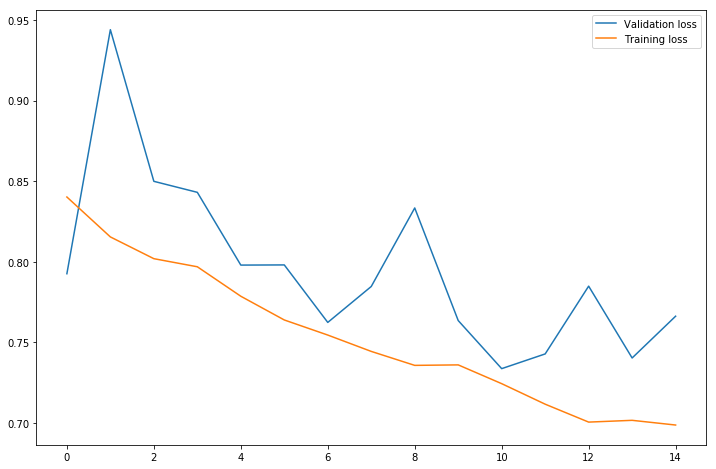

In [89]:
visualize_loss_history(model1_history)

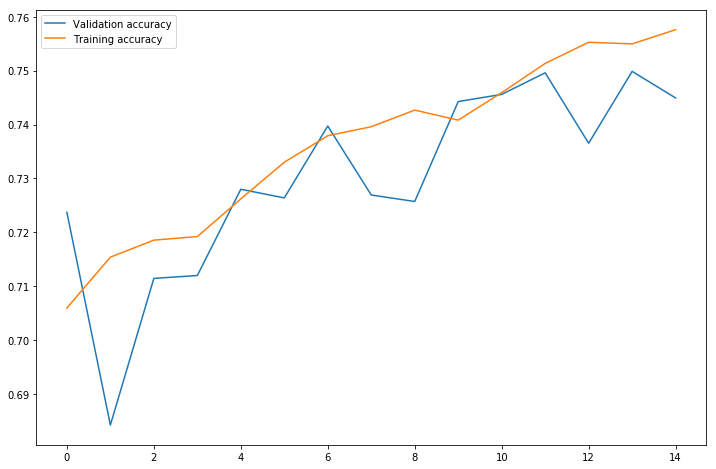

In [90]:
visualize_accuracy_history(model1_history)

### Model 3

In [56]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Conv2D(32, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.MaxPool2D())

model3.add(tf.keras.layers.Conv2D(64, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Conv2D(64, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.25))
model3.add(tf.keras.layers.BatchNormalization())

model3.add(tf.keras.layers.Conv2D(128, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.3))
model3.add(tf.keras.layers.Conv2D(128, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.MaxPool2D())
           
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(256))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.3))
model3.add(tf.keras.layers.Dense(128))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(64))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dense(num_classes))
model3.add(tf.keras.layers.Activation('softmax'))

In [57]:
opt = 'adam'

model3.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model3_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [77]:
epochs = 200

h = model3.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_val_data, y_val_data),
               shuffle=True)
model3_history = join_histories(model3_history, h.history)
save_history(model3_history, "model3_history")
save_weights(model3, "model3")

Epoch 1/200
665/665 [==============================] - 16s 24ms/step - loss: 0.7232 - acc: 0.7581 - val_loss: 0.7617 - val_acc: 0.7427
Epoch 2/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7263 - acc: 0.7570 - val_loss: 0.7232 - val_acc: 0.7528
Epoch 3/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7143 - acc: 0.7618 - val_loss: 0.7207 - val_acc: 0.7548
Epoch 4/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7037 - acc: 0.7659 - val_loss: 0.7085 - val_acc: 0.7645
Epoch 5/200
665/665 [==============================] - 15s 23ms/step - loss: 0.7130 - acc: 0.7645 - val_loss: 0.8684 - val_acc: 0.7152
Epoch 6/200
665/665 [==============================] - 15s 23ms/step - loss: 0.6906 - acc: 0.7712 - val_loss: 0.7262 - val_acc: 0.7579
Epoch 7/200
665/665 [==============================] - 15s 23ms/step - loss: 0.6846 - acc: 0.7702 - val_loss: 0.6514 - val_acc: 0.7803
Epoch 8/200
665/665 [==============================] - 

665/665 [==============================] - 16s 24ms/step - loss: 0.4544 - acc: 0.8495 - val_loss: 0.5086 - val_acc: 0.8300
Epoch 122/200
665/665 [==============================] - 16s 25ms/step - loss: 0.4509 - acc: 0.8501 - val_loss: 0.5824 - val_acc: 0.8127
Epoch 123/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4538 - acc: 0.8532 - val_loss: 0.5263 - val_acc: 0.8261
Epoch 124/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4579 - acc: 0.8493 - val_loss: 0.5639 - val_acc: 0.8157
Epoch 125/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4619 - acc: 0.8457 - val_loss: 0.5311 - val_acc: 0.8259
Epoch 126/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4581 - acc: 0.8488 - val_loss: 0.5537 - val_acc: 0.8132
Epoch 127/200
665/665 [==============================] - 16s 24ms/step - loss: 0.4571 - acc: 0.8519 - val_loss: 0.6606 - val_acc: 0.7875
Epoch 128/200
665/665 [==============================] 

In [91]:
evaluate_model(model3)
save_weights(model3, "model3")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
__________

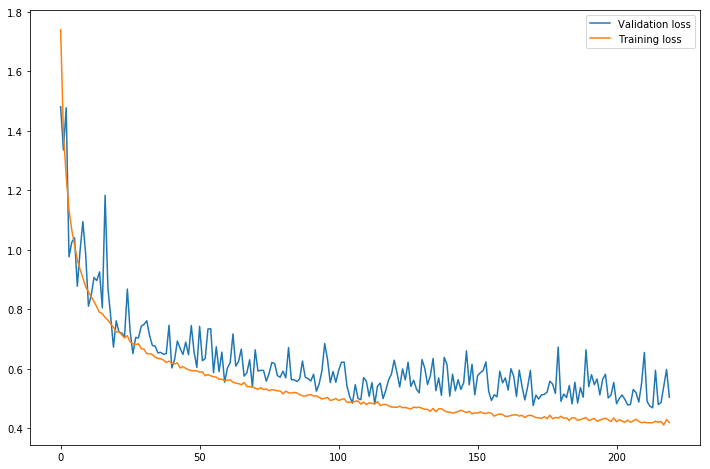

In [92]:
visualize_loss_history(model3_history)

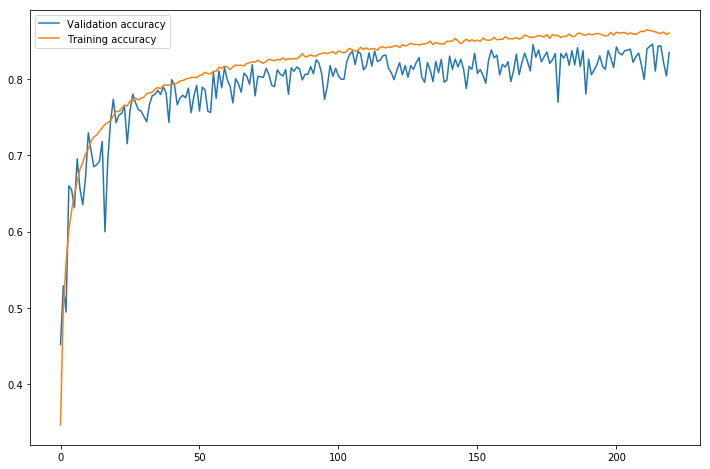

In [93]:
visualize_accuracy_history(model3_history)

## Transfer learning
### Model definition
Use VGG16 model trained on imagenet (without the last classifier layer). Then retrain the 2 last layers of vgg and add a new classifier layer.

In [62]:
vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                              weights='imagenet',
                                              input_shape=x_train_data.shape[1:])

# Disable training on all layers except last two
for layer in vgg_model.layers[:-2]:
    layer.trainable = False

model_t = tf.keras.models.Sequential()
model_t.add(vgg_model)
model_t.add(tf.keras.layers.Flatten())
model_t.add(tf.keras.layers.Dense(10, activation="softmax"))

In [72]:
batch_size = 64
epochs = 40

In [64]:
opt = 'adam'

model_t.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model_t_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [73]:
h = model_t.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val_data, y_val_data),
                      callbacks=callbacks_list,
                      shuffle=True)

model_t_history = join_histories(model_t_history, h.history)
save_history(model_t_history, "model_t_history")
save_weights(model_t, "model_t")

Epoch 1/40
664/665 [============================>.] - ETA: 0s - loss: 0.9413 - acc: 0.6657
Epoch 00001: val_acc did not improve from 0.65907
665/665 [==============================] - 17s 26ms/step - loss: 0.9412 - acc: 0.6658 - val_loss: 1.0303 - val_acc: 0.6396
Epoch 2/40
663/665 [============================>.] - ETA: 0s - loss: 0.9345 - acc: 0.6701
Epoch 00002: val_acc did not improve from 0.65907
665/665 [==============================] - 17s 25ms/step - loss: 0.9347 - acc: 0.6700 - val_loss: 0.9966 - val_acc: 0.6493
Epoch 3/40
663/665 [============================>.] - ETA: 0s - loss: 0.9172 - acc: 0.6746- ETA: 1s
Epoch 00003: val_acc did not improve from 0.65907
665/665 [==============================] - 17s 25ms/step - loss: 0.9170 - acc: 0.6748 - val_loss: 1.0413 - val_acc: 0.6332
Epoch 4/40
664/665 [============================>.] - ETA: 0s - loss: 0.9025 - acc: 0.6783
Epoch 00004: val_acc improved from 0.65907 to 0.67120, saving model to weights-improvement-mt-004-0.67.hdf5


Epoch 31/40
664/665 [============================>.] - ETA: 0s - loss: 0.7394 - acc: 0.7345- ETA: 8s - loss: 0.7 - ETA - ETA: 2s - ETA: 1s - loss: 0.7372 - acc: - ETA: 0s - loss: 0.7370 - acc
Epoch 00031: val_acc did not improve from 0.67773
665/665 [==============================] - 17s 25ms/step - loss: 0.7392 - acc: 0.7345 - val_loss: 0.9628 - val_acc: 0.6775
Epoch 32/40
664/665 [============================>.] - ETA: 0s - loss: 0.7416 - acc: 0.7349- ETA: 3s - loss: 0.7
Epoch 00032: val_acc did not improve from 0.67773
665/665 [==============================] - 17s 25ms/step - loss: 0.7418 - acc: 0.7349 - val_loss: 1.0300 - val_acc: 0.6565
Epoch 33/40
663/665 [============================>.] - ETA: 0s - loss: 0.7341 - acc: 0.7375
Epoch 00033: val_acc did not improve from 0.67773
665/665 [==============================] - 17s 25ms/step - loss: 0.7351 - acc: 0.7372 - val_loss: 1.0019 - val_acc: 0.6617
Epoch 34/40
663/665 [============================>.] - ETA: 0s - loss: 0.7297 - acc:

In [94]:
evaluate_model(model_t)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 14,719,818
Trainable params: 2,364,938
Non-trainable params: 12,354,880
_________________________________________________________________
10000/10000 [==============================] - 3s 347us/step
Test loss: 1.0314, accuracy: 0.6732


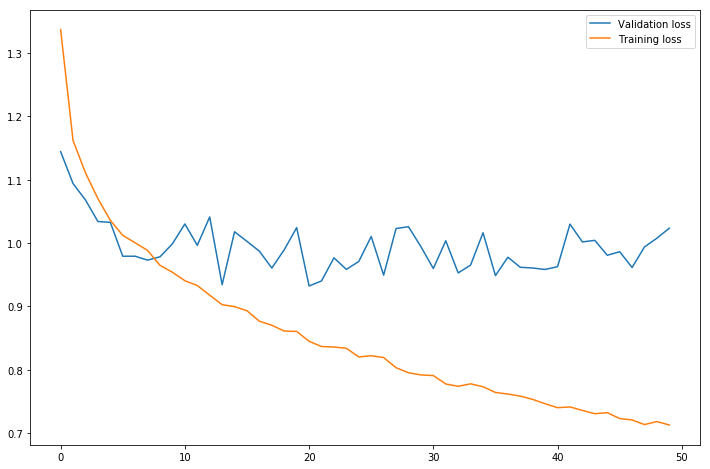

In [95]:
visualize_loss_history(model_t_history)

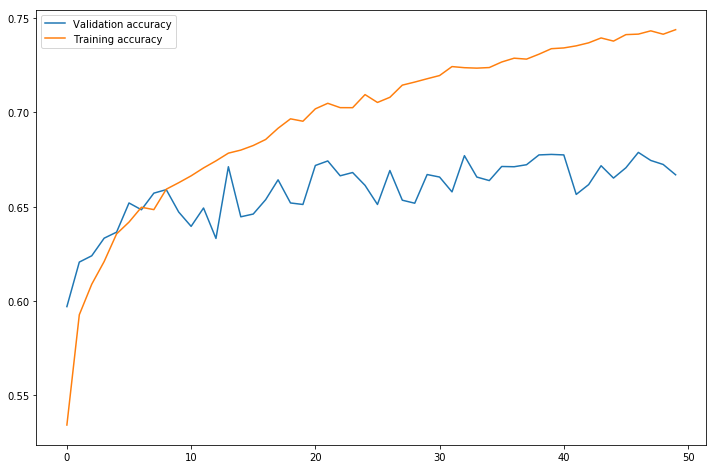

In [96]:
visualize_accuracy_history(model_t_history)

### Transfer Learning using ResNet50

In [102]:
resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                         weights='imagenet',
                                                         input_shape=x_train_data.shape[1:])

# Disable training on all layers except last two
for layer in resnet50_model.layers[:-2]:
    layer.trainable = False

model_t_resnet = tf.keras.models.Sequential()
model_t_resnet.add(vgg_model)
model_t_resnet.add(tf.keras.layers.Flatten())
model_t_resnet.add(tf.keras.layers.Dense(1024, activation="relu"))
model_t_resnet.add(tf.keras.layers.Dense(1024, activation="relu"))
model_t_resnet.add(tf.keras.layers.Dropout(0.3))
model_t_resnet.add(tf.keras.layers.Dense(512, activation="relu"))
model_t_resnet.add(tf.keras.layers.Dropout(0.2))
model_t_resnet.add(tf.keras.layers.Dense(10, activation="softmax"))

In [103]:
opt = 'adam'

model_t_resnet.compile(loss='categorical_crossentropy',
                       optimizer=opt,
                       metrics=['accuracy'])

model_t_resnet_history = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': []
    }

In [116]:
batch_size = 64
epochs = 10

In [ ]:
for i in range(100):
    h = model_t_resnet.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_data=(x_val_data, y_val_data),
                           callbacks=callbacks_list,
                           shuffle=True)

    model_t_resnet_history = join_histories(model_t_resnet_history, h.history)
    save_history(model_t_resnet_history, "model_t_resnet_history")
    save_weights(model_t_resnet, "model_t_resnet")

Epoch 1/10
664/665 [============================>.] - ETA: 0s - loss: 0.6974 - acc: 0.7630
Epoch 00001: val_acc did not improve from 0.67907
665/665 [==============================] - 20s 30ms/step - loss: 0.6976 - acc: 0.7630 - val_loss: 1.0298 - val_acc: 0.6732
Epoch 2/10
664/665 [============================>.] - ETA: 0s - loss: 0.6820 - acc: 0.7688
Epoch 00002: val_acc did not improve from 0.67907
665/665 [==============================] - 20s 30ms/step - loss: 0.6822 - acc: 0.7687 - val_loss: 1.0273 - val_acc: 0.6643
Epoch 3/10
664/665 [============================>.] - ETA: 0s - loss: 0.6877 - acc: 0.7678
Epoch 00003: val_acc did not improve from 0.67907
665/665 [==============================] - 20s 30ms/step - loss: 0.6875 - acc: 0.7678 - val_loss: 1.0153 - val_acc: 0.6668
Epoch 4/10
664/665 [============================>.] - ETA: 0s - loss: 0.6857 - acc: 0.7694
Epoch 00004: val_acc improved from 0.67907 to 0.68107, saving model to weights-improvement-mt-004-0.68.hdf5
665/665 [

In [111]:
evaluate_model(model_t_resnet)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
__________

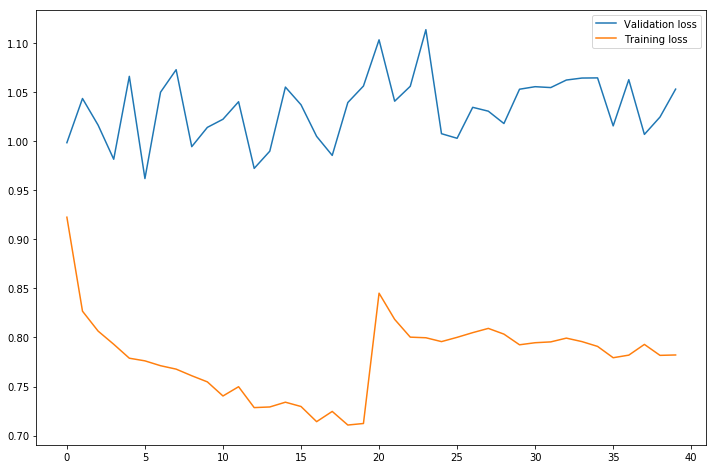

In [112]:
visualize_loss_history(model_t_resnet_history)

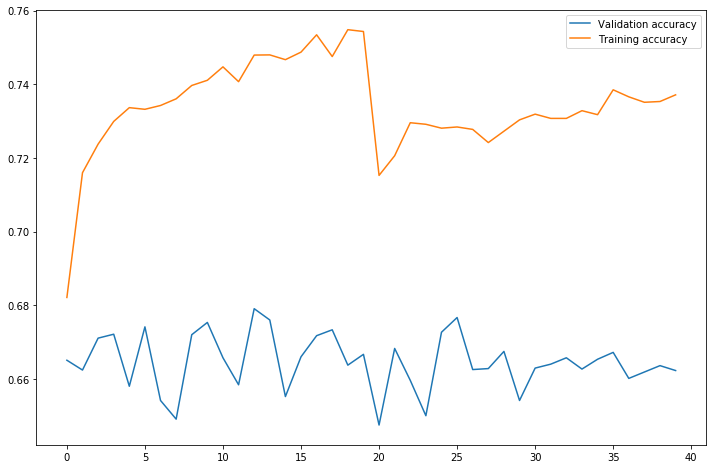

In [113]:
visualize_accuracy_history(model_t_resnet_history)